In [3]:
from ml_toolkit import df_to_X_y
from ml_toolkit import plot_predictions

import os
import sys
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Serif'

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam


| Date                | Point_1_N_mean | PT100_Temperature_mean | Average_Global_Radiation_(1h) | Day sin          | Day cos          | Year sin       | Year cos       |
|---------------------|----------------|------------------------|-------------------------------|------------------|------------------|----------------|----------------|
| 2020-09-02 12:00:00 | 18.324186      | 16.261441              | 954.0                         | 7.392965e-12     | -1.000000e+00    | -0.961130      | -0.276097      |
| 2020-09-03 12:00:00 | 24.667922      | 16.858222              | 966.0                         | 3.094426e-12     | -1.000000e+00    | -0.965740      | -0.259512      |
| 2020-09-04 10:00:00 | -15.535099     | 14.256647              | 131.6                         | 5.000000e-01     | -8.660254e-01    | -0.969715      | -0.244241      |
| 2020-09-04 14:00:00 | -10.819921     | 14.687477              | 314.0                         | -5.000000e-01    | -8.660254e-01    | -0.970411      | -0.241458      |
| 2020-09-04 18:00:00 | -15.399971     | 13.874647              | 236.0                         | -1.000000e+00    | -1.359232e-12    | -0.971100      | -0.238673      |


# Loading data

In [5]:
git_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML'))
asset_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML-Assets'))

print("Path to git folder:", git_folder)
print("Path to asset folder:", asset_folder)

Path to git folder: c:\Users\erlih\repos\HeroysundBridge-ML
Path to asset folder: c:\Users\erlih\repos\HeroysundBridge-ML-Assets


**Opening file: \silver\combined with relevant columns**

In [6]:
df = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
df.index = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df.to_csv(os.path.join(asset_folder, 'silver','inspection.csv'))

**Adding relevant time/dates columns**

,Point_6_S_mean,PT100_Temperature_mean,Average_Global_Radiation_(1h),Relative_Humidity(1h),Precipitation_(1h),Average_of_Mean_Wind_(1h),Day sin,Day cos,Year sin,Year cos,days_since_start
Date,,,,,,,,,,,
2020-10-01 00:00:00,-22.681829,12.476844,0.0,71.0,0.0,1.1,-8.575893e-12,1.000000e+00,-0.977848,0.209315,0
2020-10-01 01:00:00,-25.236402,12.202079,0.0,75.0,0.0,1.5,2.588190e-01,9.659258e-01,-0.977698,0.210016,0
2020-10-01 02:00:00,-27.953711,11.993529,0.0,72.0,0.0,1.8,5.000000e-01,8.660254e-01,-0.977547,0.210717,0
2020-10-01 03:00:00,-30.408096,11.865803,0.0,77.0,0.0,1.8,7.071068e-01,7.071068e-01,-0.977396,0.211418,0
2020-10-01 04:00:00,-32.365598,11.889412,0.0,76.0,0.0,1.8,8.660254e-01,5.000000e-01,-0.977244,0.212119,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 18:00:00,-257.119294,-4.738139,-3.0,60.0,0.0,1.1,-1.000000e+00,-1.136945e-11,0.217723,0.976011,1186
2023-12-31 19:00:00,-256.383557,-4.625233,-3.0,59.0,0.0,1.3,-9.659258e-01,2.588190e-01,0.218423,0.975854,1186
2023-12-31 20:00:00,-258.295017,-4.645648,-2.9,57.0,0.0,1.3,-8.660254e-01,5.000000e-01,0.219123,0.975697,1186


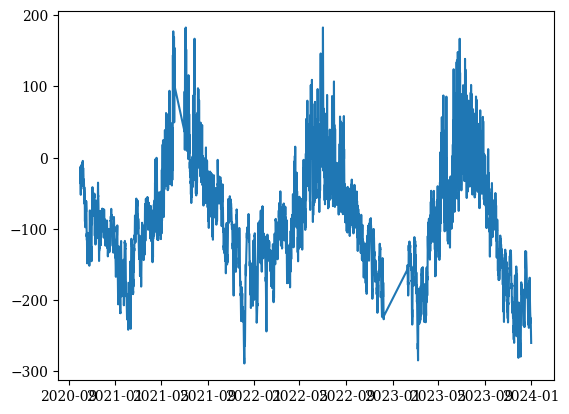

In [7]:
model_dataset = df[['Point_6_S_mean', 'PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]['2020-10-01 00:00:00':]#
model_dataset['seconds'] = model_dataset.index.map(pd.Timestamp.timestamp)
model_dataset['Day sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 86400))
model_dataset['Day cos'] = np.cos(model_dataset['seconds'] * (2 * np.pi / 86400))
model_dataset['Year sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 31536000))
model_dataset['Year cos'] = np.cos(model_dataset['seconds'] * (2 * np.pi / 31536000))
model_dataset['days_since_start'] = (model_dataset.index - model_dataset.index[0]).days
model_dataset.drop(columns=['seconds'], inplace=True)
display(model_dataset)
plt.plot(model_dataset.index, model_dataset['Point_6_S_mean'])

# Train-, val- and testing split +++ Scaling

In [8]:
dataset_size = len(model_dataset)
training_split = int(0.72 * dataset_size)
validation_split = int(0.18 * dataset_size)
test_split = dataset_size - training_split - validation_split
print(f"Training split: {training_split}, Validation split: {validation_split}, Test split: {test_split}")
assert training_split + validation_split + test_split == dataset_size, "Invalid split sizes"

Training split: 19000, Validation split: 4750, Test split: 2640


In [9]:
print(model_dataset[:training_split])
print("-------------------")
print(model_dataset[training_split:-test_split])
print("-------------------")
print(model_dataset[-test_split:])

                     Point_6_S_mean  PT100_Temperature_mean  \
Date                                                          
2020-10-01 00:00:00      -22.681829               12.476844   
2020-10-01 01:00:00      -25.236402               12.202079   
2020-10-01 02:00:00      -27.953711               11.993529   
2020-10-01 03:00:00      -30.408096               11.865803   
2020-10-01 04:00:00      -32.365598               11.889412   
...                             ...                     ...   
2023-02-27 01:00:00     -125.969246                4.486058   
2023-02-27 02:00:00     -125.969880                4.555233   
2023-02-27 03:00:00     -126.237242                4.561771   
2023-02-27 04:00:00     -126.476872                4.451549   
2023-02-27 05:00:00     -126.989811                4.327346   

                     Average_Global_Radiation_(1h)  Relative_Humidity(1h)  \
Date                                                                        
2020-10-01 00:00:00       

**Assigning labels and targets - x- and y- train,-val and -test**

In [10]:
window_size = 24*30

X, y = df_to_X_y(model_dataset, window_size)
print(X.shape, y.shape)

# Splitting the data into training, validation and test sets
X_train, y_train = X[:training_split], y[:training_split]
X_valid, y_valid = X[training_split:(training_split + validation_split)], y[training_split:(training_split + validation_split)]
X_test, y_test = X[-test_split:], y[-test_split:]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(25670, 720, 10) (25670,)
(19000, 720, 10) (19000,) (4750, 720, 10) (4750,) (2640, 720, 10) (2640,)


**Normlaization**

In [11]:
# Reshape to 2D (Normalisation requires 2D input)
X_train_2D = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
X_valid_2D = np.reshape(X_valid, (X_valid.shape[0] * X_valid.shape[1], X_valid.shape[2]))
X_test_2D = np.reshape(X_test, (X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

# Apply scaling
scaler_x = StandardScaler()
X_train_scaled_2D = scaler_x.fit_transform(X_train_2D)
X_valid_scaled_2D = scaler_x.transform(X_valid_2D)
X_test_scaled_2D = scaler_x.transform(X_test_2D)

# Reshape back to 3D
X_train_scaled = np.reshape(X_train_scaled_2D, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid_scaled = np.reshape(X_valid_scaled_2D, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test_scaled = np.reshape(X_test_scaled_2D, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# LSTM Model 2

In [1]:
model_name = 'lstm_model_point_6_S_001'
batch_size = 128
epochs = 200
learning_rate = 0.001
patience = 12
verbose = 1
saving_frequency = 8

In [ ]:
model = Sequential()
model.add(InputLayer((window_size, (len(model_dataset.columns)-1))))
#model.add(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
#model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5504      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5537 (21.63 KB)
Trainable params: 5537 (21.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint(os.path.join(asset_folder, 'gold', str(model_name)), save_best_only=True, mode='auto', verbose=verbose)
es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', verbose=verbose)
model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mae'])
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled), epochs=epochs, batch_size=batch_size, callbacks=[es,cp], verbose=verbose) 

Epoch 1/200


149/149 [==============================] - ETA: 0s - loss: 0.1965 - mae: 0.3180
Epoch 1: val_loss improved from inf to 0.26343, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 82s 542ms/step - loss: 0.1965 - mae: 0.3180 - val_loss: 0.2634 - val_mae: 0.4335
Epoch 2/200
149/149 [==============================] - ETA: 0s - loss: 0.0795 - mae: 0.2185
Epoch 2: val_loss improved from 0.26343 to 0.18448, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 80s 536ms/step - loss: 0.0795 - mae: 0.2185 - val_loss: 0.1845 - val_mae: 0.3512
Epoch 3/200
149/149 [==============================] - ETA: 0s - loss: 0.0675 - mae: 0.2017
Epoch 3: val_loss did not improve from 0.18448
149/149 [==============================] - 79s 529ms/step - loss: 0.0675 - mae: 0.2017 - val_loss: 0.1852 - val_mae: 0.3511
Epoch 4/200
149/149 [==============================] - ETA: 0s - loss: 0.0583 - mae: 0.1866
Epoch 4: val_loss improved from 0.18448 to 0.13893, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 80s 540ms/step - loss: 0.0583 - mae: 0.1866 - val_loss: 0.1389 - val_mae: 0.3038
Epoch 5/200
149/149 [==============================] - ETA: 0s - loss: 0.0525 - mae: 0.1765
Epoch 5: val_loss improved from 0.13893 to 0.09972, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 80s 537ms/step - loss: 0.0525 - mae: 0.1765 - val_loss: 0.0997 - val_mae: 0.2561
Epoch 6/200
149/149 [==============================] - ETA: 0s - loss: 0.0482 - mae: 0.1704
Epoch 6: val_loss improved from 0.09972 to 0.07430, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 81s 541ms/step - loss: 0.0482 - mae: 0.1704 - val_loss: 0.0743 - val_mae: 0.2173
Epoch 7/200
149/149 [==============================] - ETA: 0s - loss: 0.0455 - mae: 0.1647
Epoch 7: val_loss did not improve from 0.07430
149/149 [==============================] - 83s 556ms/step - loss: 0.0455 - mae: 0.1647 - val_loss: 0.0958 - val_mae: 0.2468
Epoch 8/200
149/149 [==============================] - ETA: 0s - loss: 0.0424 - mae: 0.1594
Epoch 8: val_loss improved from 0.07430 to 0.06971, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 79s 531ms/step - loss: 0.0424 - mae: 0.1594 - val_loss: 0.0697 - val_mae: 0.2133
Epoch 9/200
149/149 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.1544
Epoch 9: val_loss did not improve from 0.06971
149/149 [==============================] - 78s 521ms/step - loss: 0.0399 - mae: 0.1544 - val_loss: 0.0761 - val_mae: 0.2255
Epoch 10/200
149/149 [==============================] - ETA: 0s - loss: 0.0388 - mae: 0.1520
Epoch 10: val_loss did not improve from 0.06971
149/149 [==============================] - 79s 530ms/step - loss: 0.0388 - mae: 0.1520 - val_loss: 0.0758 - val_mae: 0.2230
Epoch 11/200
149/149 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.1485
Epoch 11: val_loss did not improve from 0.06971
149/149 [==============================] - 79s 531ms/step - loss: 0.0370 - mae: 0.1485 - val_loss: 0.1136 - val_mae: 0.2615
Epoch 12/200
149/149 [==============================] - ETA: 0s - loss: 0.0362 - ma

INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_point_6_S_001\assets


149/149 [==============================] - 81s 547ms/step - loss: 0.0336 - mae: 0.1409 - val_loss: 0.0673 - val_mae: 0.2056
Epoch 17/200
149/149 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.1392
Epoch 17: val_loss did not improve from 0.06733
149/149 [==============================] - 80s 535ms/step - loss: 0.0326 - mae: 0.1392 - val_loss: 0.0809 - val_mae: 0.2211
Epoch 18/200
149/149 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.1382
Epoch 18: val_loss did not improve from 0.06733
149/149 [==============================] - 80s 535ms/step - loss: 0.0319 - mae: 0.1382 - val_loss: 0.0869 - val_mae: 0.2310
Epoch 19/200
149/149 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.1387
Epoch 19: val_loss did not improve from 0.06733
149/149 [==============================] - 79s 533ms/step - loss: 0.0323 - mae: 0.1387 - val_loss: 0.0676 - val_mae: 0.2004
Epoch 20/200
149/149 [==============================] - ETA: 0s - loss: 0.0309 - 

**Visualization of ML-metrics**

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Get the index of the best model
best_model_index = np.argmin(val_loss)

# Plot the training loss vs validation loss
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(best_model_index + 1, val_loss[best_model_index], color='g', label='Best Model')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss [MSE]',fontsize=16)
plt.legend(fontsize=14)

# Display the MAE value of the best model
best_model_mae = val_loss[best_model_index]
plt.annotate(f'MAE: {best_model_mae:.4f}', (best_model_index + 1, best_model_mae), xytext=(10, 10),
             textcoords='offset points', color='g')

plt.show()

NameError: name 'history' is not defined

### Predictions



83/83 [==============================] - 11s 135ms/step


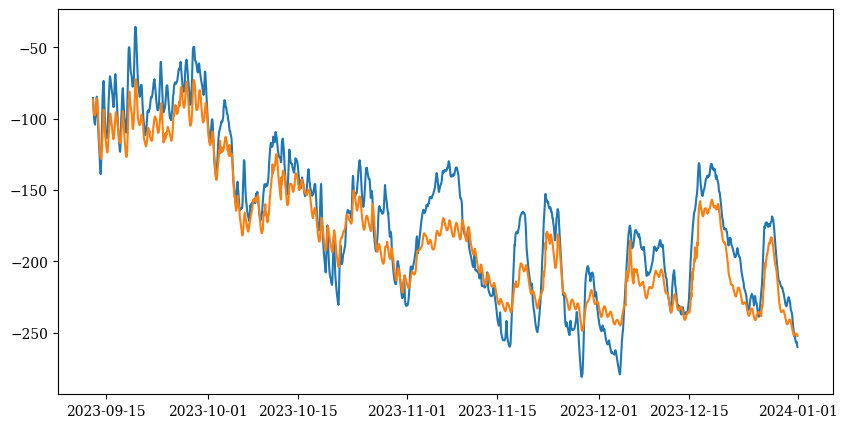

MSE: 393.26751708984375
MAE: 16.773317337036133
R^2 Score: 0.8659451362330429


,Predictions,Actuals
0,-86.529465,-85.490389
1,-89.944969,-88.955957
2,-92.565491,-92.945329
3,-94.842796,-96.300671
4,-96.670670,-98.819592
...,...,...
2635,-250.572800,-257.119294
2636,-250.768066,-256.383557
2637,-251.026459,-258.295017
2638,-251.599197,-259.567834


In [12]:
from sklearn.metrics import r2_score as score

model_file_path = os.path.join(asset_folder, 'gold', model_name)
model = load_model(model_file_path)
plot_predictions(model_dataset, test_split, model, X_test_scaled, y_test, start=0, end=test_split, scaler=scaler_y)
#print(f"R^2 Score: {score(X_test_scaled, y_test)}")